In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wn
wn.filterwarnings('ignore')

In [4]:
data=pd.read_csv(r'D:\python_codes\credit_risk_analysis\UCI_Credit_Card.csv')
df=data.copy()

In [5]:
# Renaming the dependent column name # type:ignore
df.rename(columns={
    "default.payment.next.month": "default"
}, inplace=True)

In [6]:
# Finding the null value
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [7]:
# Analysing the data types of each data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [8]:
# Viewing the dependent feature to find whether the data is imbalance or not
credit_count=df['default'].value_counts()
credit_count

default
0    23364
1     6636
Name: count, dtype: int64

In [9]:
credit_unique=df['default'].unique()

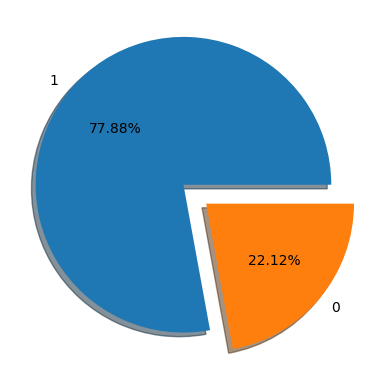

In [10]:
# Visualizing the depedent featuer using pie chart
explode = [0.1,0.1]
plt.pie(credit_count,labels=credit_unique,autopct='%.2f%%',explode=explode,shadow=True)
plt.show()

OBSERVATION:
    
    @ 0 --> 22.12%
    @ 1 --> 77.88%

imbalance dataset. So, there is a need to apply SMOTE or any other sampling techique

<Axes: >

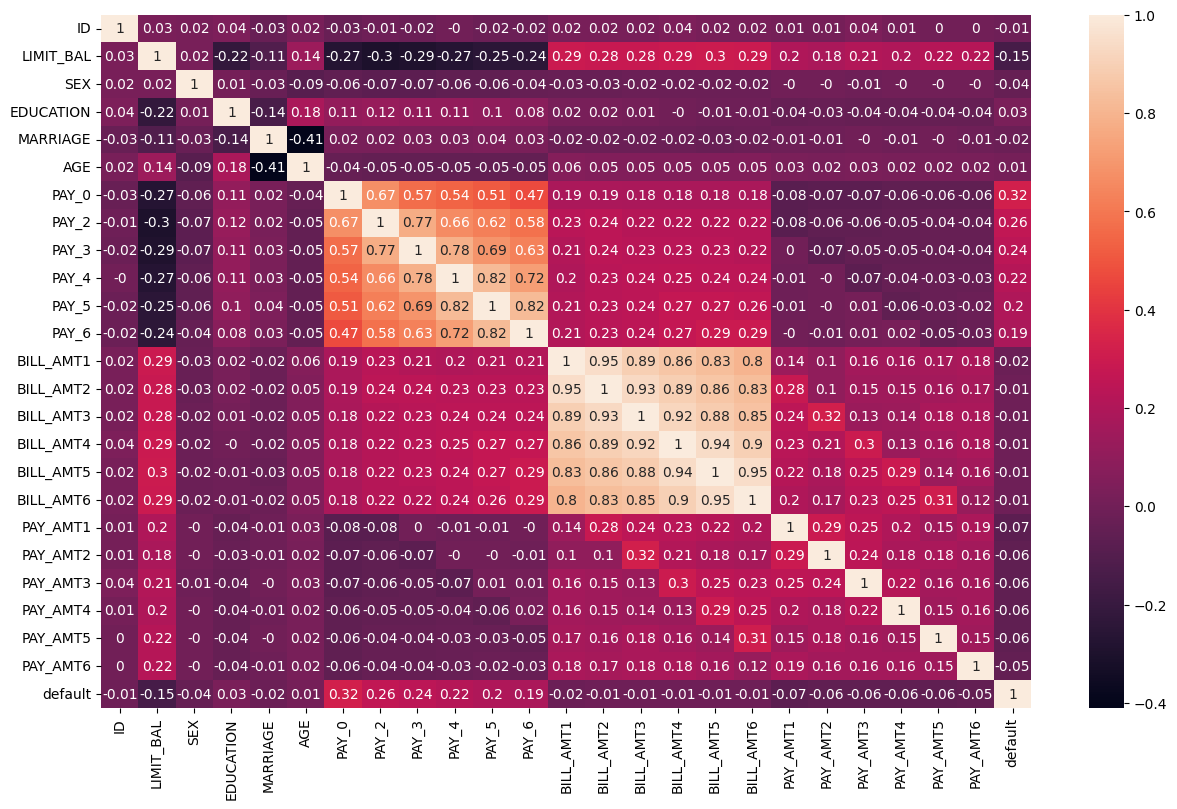

In [11]:
# Finding the relationship between the features using correletion
plt.figure(figsize=(15,9))
sns.heatmap(df.corr().round(2),annot=True)

In [12]:
# Seperating dependent and independent feature
x= df.drop(['ID', 'default'], axis=1) #independent feature 
y=df['default'] #dependent feature 

In [13]:
# splitting the data into train and test and applying the standardizing tho train and test data to prevent data leakage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=44)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [14]:
# Applying the sampling technique to overcome the imbalance
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_sampled,y_sampled=smote.fit_resample(x_train,y_train) 

In [15]:
# Applying XGBoot classifier to train the data, Which is a powerful algorithm to train the data and also finding the performance metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from xgboost import XGBClassifier
md=XGBClassifier()
md.fit(x_sampled,y_sampled)
y_pred=md.predict(x_test)# type:ignore
y_test_proba = md.predict_proba(x_test)[:,1]
print('Model : XGBClassifier')

print('accuracy_score=',accuracy_score(y_test,y_pred))
print('precision_score=',precision_score(y_test,y_pred))
print('recall_score=',recall_score(y_test,y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_proba)) 
print()

Model : XGBClassifier
accuracy_score= 0.8074666666666667
precision_score= 0.5860621326616289
recall_score= 0.42328684050939963
ROC AUC Score: 0.747399049303924



In [16]:
# create explainer for your trained tree model
import shap
explainer = shap.TreeExplainer(md)

In [17]:
# compute SHAP values for test data
shap_values = explainer.shap_values(x_test)

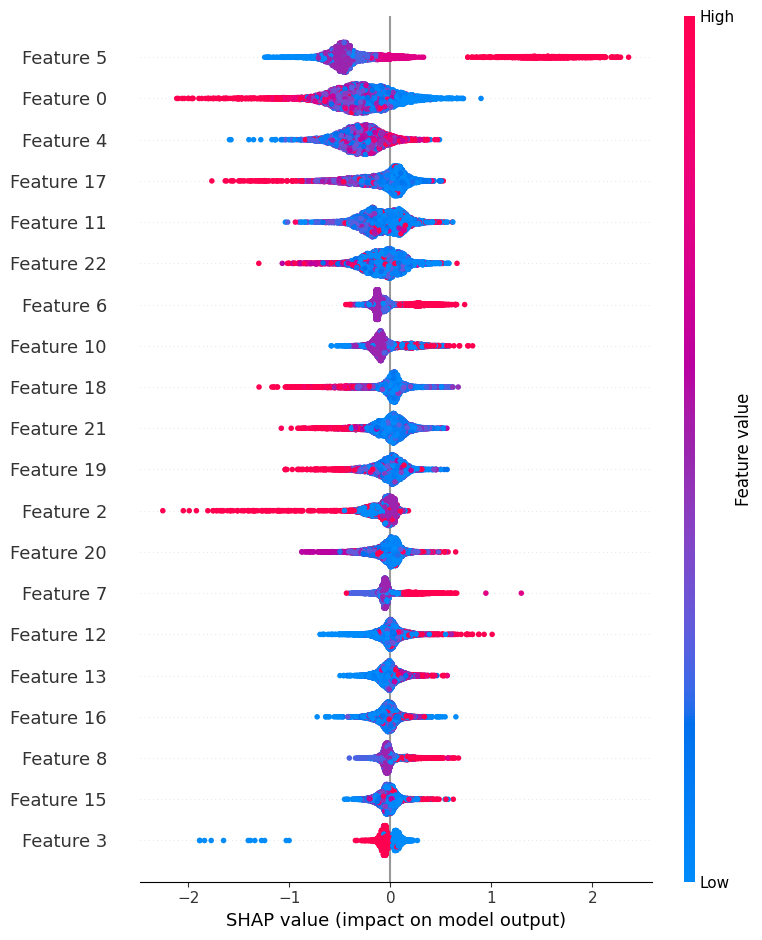

In [18]:
 # plot feature importance across all samples
shap.summary_plot(shap_values, x_test) 

Here’s your SHAP summary distilled into clear bullet points:

---> Feature 5

    Strongest influence on predictions

    High values (red) → model output increases significantly

---> Feature 0

    Major role but opposite effect

    Higher values -> prediction score decreases

---> Moderate impact features

    Feature 4

    Feature 11

    Feature 17

---> Low impact features

    Feature 1

    Feature 14

---> Overall insight

    Model is driven mainly by a handful of key features



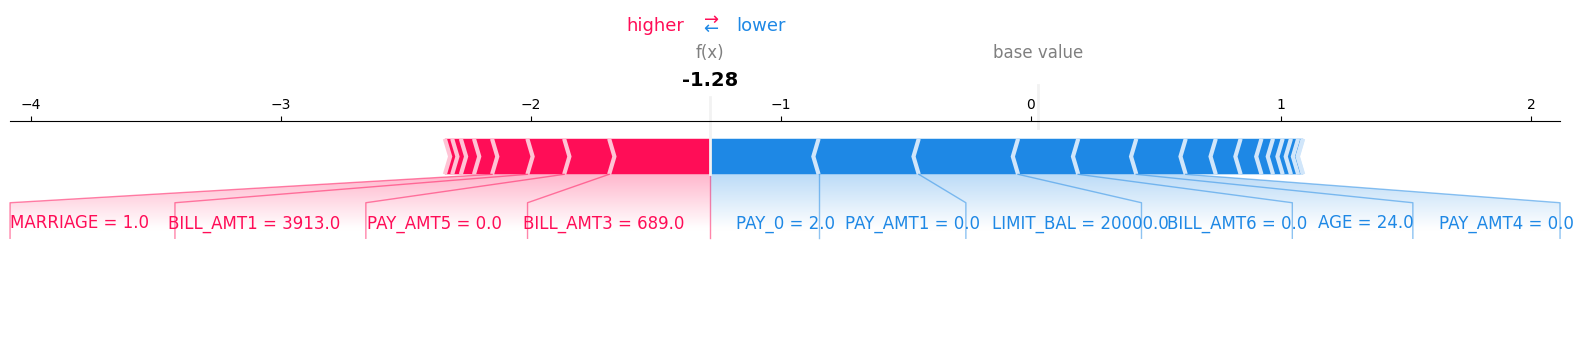

In [19]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    x.iloc[0,:],
    matplotlib=True
)

Key Insights

    Most influential negative factor: PAY_0 = 2.0 — this likely reflects a payment delay of two months, which heavily penalizes the prediction.

    Positive signals like LIMIT_BAL and BILL_AMT1 help, but not enough to offset the negative impact of missed payments and young age.

    The model seems to associate payment history and age with risk more strongly than billing amounts or credit limit.